# `CLOUD.jl` - 2D linear advection

In [110]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../plots/advection_collapsed_2D_skew_p3M6/"
results_path = "../results/advection_collapsed_2D_skew_p3M6/";

Define the physical problem

In [111]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=0.0);

Set up a collapsed-edge scheme of degree `p` with `M` intervals in each direction

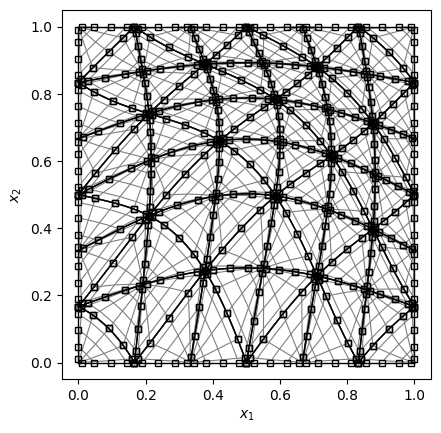

In [112]:
M = 6
p = 4
p_map = p
form = WeakConservationForm(CreanMapping())
mesh_strategy = ZigZag()

reference_approximation =ReferenceApproximation(
    DGSEM(p), CollapsedTri(),
    volume_quadrature_rule=(LGQuadrature(),LGRQuadrature()),
    facet_quadrature_rule=(LGQuadrature(),LGRQuadrature()), 
    chain_rule_diff=true, mapping_degree=p_map,
    N_plot=ceil(Int,50/M));
mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M), strategy=mesh_strategy), 
    reference_approximation.reference_element, 0.1)
spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation);
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, 
     (0.0, T), Lazy(), results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf", 
    grid_lines=true, plot_volume_nodes=false, geometry_resolution=20)

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [113]:
reset_timer!()
n_s = 2
dt_scale=0.01
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, Tsit5(), adaptive=false,
    dt=dt, save_everystep=false, krylov=:adaptive,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final")

Visualize the solution

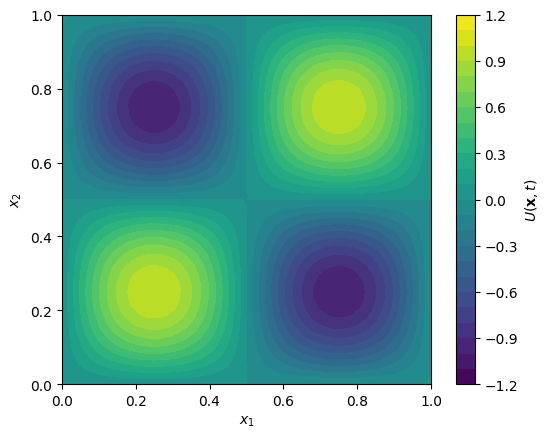

In [114]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

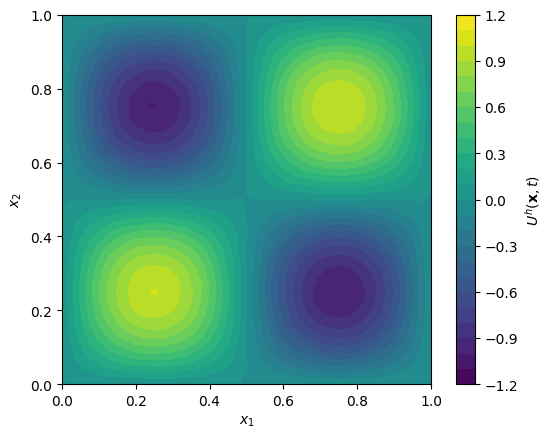

In [115]:
visualize(last(sol.u),plotter, "approx.pdf", contours=25, u_range=[-1.0,1.0],
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [116]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error:
[0.0030275983114390354]
Conservation (initial/final/diff):
[-2.2724022516115716e-9][-2.2724021708385098e-9][8.077306185017008e-17]
Energy (initial/final/diff):
[0.2500000738087627][0.25000007380876227][-4.440892098500626e-16]


In [117]:
check_sbp_property(reference_approximation)

(3.3084646133829665e-14, 4.9960036108132044e-15)